# Estrategia de pricing
**Discriminación de precios de tercer grado**

Autor: Sergio Diaz Paredes

Contacto: [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)

## Caso de estudio: Optimización de ingresos mediante discriminación de precios

Una empresa que distribuye un producto en diferentes zonas de una ciudad desea maximizar sus ingresos aplicando una estrategia de precios diferenciados. Para lograr esto, utiliza un modelo de optimización que le permite ajustar los precios en función de la elasticidad de la demanda en cada zona. El objetivo es asignar precios de manera que se maximicen los ingresos totales, considerando cómo varía la demanda en cada zona según el precio del producto.

## Paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## Cargar dataset

In [2]:
data_all = pd.read_csv("segmented_pricing_dataset.csv")
data_all['fecha'] = pd.to_datetime(data_all['fecha'])
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     1491 non-null   datetime64[ns]
 1   zona      1491 non-null   object        
 2   precio    1491 non-null   float64       
 3   cantidad  1491 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 46.7+ KB


## EDA

In [3]:
data_all.head()

,fecha,zona,precio,cantidad
0,2018-01-01,Centro,13.7,195
1,2018-01-01,Norte,13.7,149
2,2018-01-01,Sur,13.7,168
3,2018-01-02,Centro,13.7,221
4,2018-01-02,Norte,13.7,179


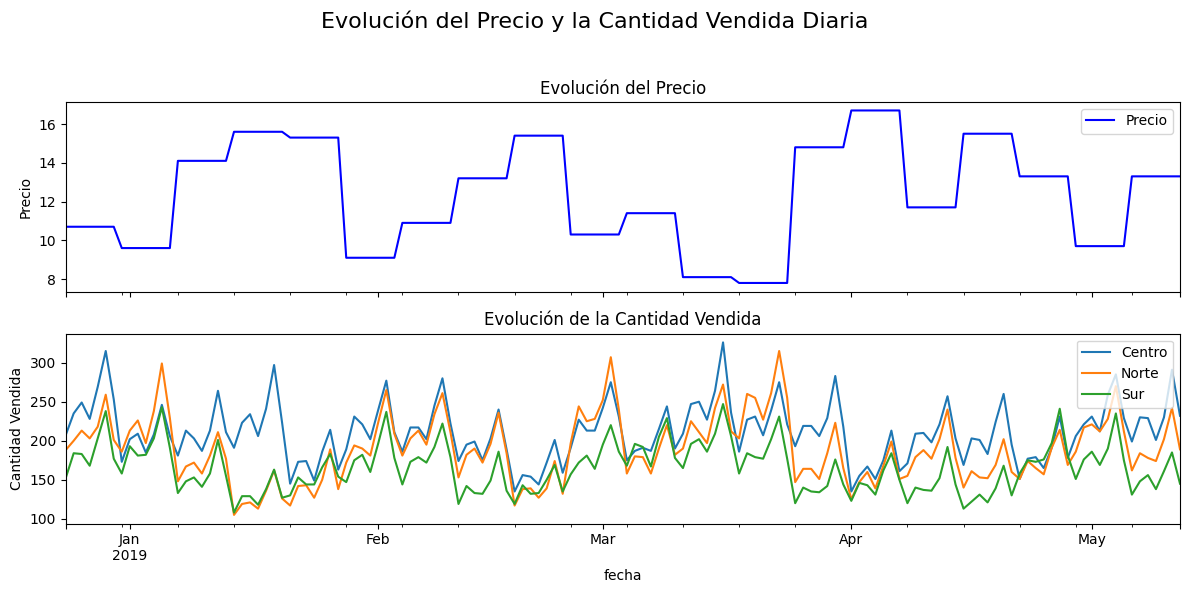

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Graficar el precio en el primer subgráfico
data_all.set_index('fecha')['precio'][-(140*3):].plot(ax=axes[0], color='blue', label='Precio')
axes[0].set_title('Evolución del Precio')
axes[0].set_ylabel('Precio')
axes[0].legend()

# Graficar la cantidad vendida en el segundo subgráfico
data_all.pivot_table(index='fecha',columns='zona',values='cantidad')[-140:].plot(ax=axes[1])
axes[1].set_title('Evolución de la Cantidad Vendida')
axes[1].set_ylabel('Cantidad Vendida')
axes[1].legend()

# Título principal
fig.suptitle('Evolución del Precio y la Cantidad Vendida Diaria', fontsize=16)

# Ajustar el espacio entre subgráficos
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título principal

plt.show()

## Estacionalidad Semanal

In [5]:
# Extraer el número del día de la semana (lunes=0, domingo=6)
data_all['dia_sem'] = data_all['fecha'].dt.weekday

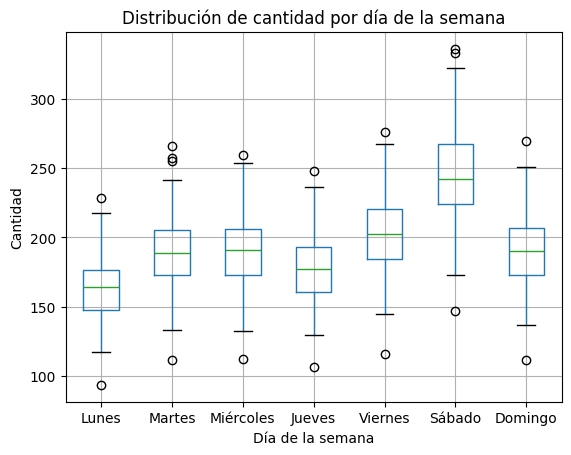

In [6]:
data_all.pivot_table(index='fecha', columns='dia_sem', values='cantidad').boxplot()
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.xticks(ticks=range(1, len(dias_semana) + 1), labels=dias_semana)

# Mostrar el gráfico
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.title('Distribución de cantidad por día de la semana')
plt.show()

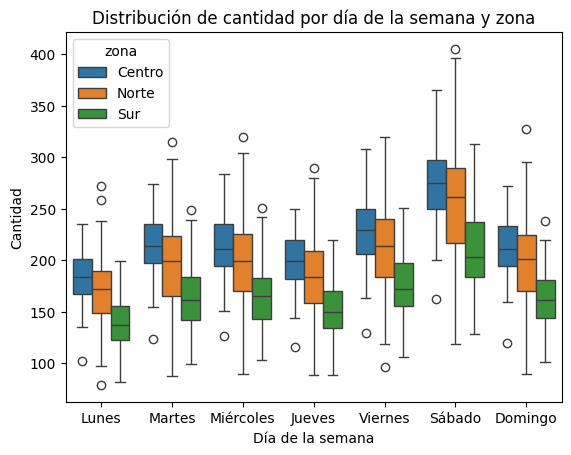

In [7]:
sns.boxplot(data=data_all, x='dia_sem', y='cantidad', hue='zona')
plt.xticks(ticks=range(len(dias_semana)), labels=dias_semana)
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad')
plt.title('Distribución de cantidad por día de la semana y zona')
plt.show()

## Agregación semanal

In [8]:
data = data_all.pivot_table(index='fecha',columns='zona',values='cantidad').reset_index()
data['precio'] = data_all.pivot_table(index='fecha',values='precio').reset_index()['precio']

In [9]:
data

zona,fecha,Centro,Norte,Sur,precio
0,2018-01-01,195.0,149.0,168.0,13.7
1,2018-01-02,221.0,179.0,183.0,13.7
2,2018-01-03,217.0,185.0,197.0,13.7
3,2018-01-04,219.0,160.0,170.0,13.7
4,2018-01-05,252.0,192.0,201.0,13.7
...,...,...,...,...,...
492,2019-05-08,229.0,178.0,156.0,13.3
493,2019-05-09,201.0,174.0,138.0,13.3
494,2019-05-10,230.0,202.0,161.0,13.3
495,2019-05-11,291.0,242.0,185.0,13.3


In [10]:
# Crear un identificador de semana desde la primera fecha del dataset
data['semana'] = ((data['fecha'] - data['fecha'].min()).dt.days // 7)

In [11]:
# Agrupar por semana y calcular las métricas necesarias
weekly_data = data.groupby('semana').agg(
    Centro=('Centro', 'sum'),
    Norte=('Norte', 'sum'),
    Sur=('Sur', 'sum'),
    precio=('precio', 'mean')
)
weekly_data.head()

,Centro,Norte,Sur,precio
semana,,,,
0,1622.0,1278.0,1353.0,13.7
1,1519.0,1343.0,1377.0,11.5
2,1598.0,847.0,1193.0,14.3
3,879.0,651.0,867.0,17.3
4,1653.0,1516.0,1109.0,11.2


In [12]:
# Crear una columna opcional para identificar la semana con la fecha inicial de cada grupo
weekly_data['fecha_inicio_semana'] = data.groupby('semana')['fecha'].min().values

In [13]:
weekly_data

,Centro,Norte,Sur,precio,fecha_inicio_semana
semana,,,,,
0,1622.0,1278.0,1353.0,13.7,2018-01-01
1,1519.0,1343.0,1377.0,11.5,2018-01-08
2,1598.0,847.0,1193.0,14.3,2018-01-15
3,879.0,651.0,867.0,17.3,2018-01-22
4,1653.0,1516.0,1109.0,11.2,2018-01-29
...,...,...,...,...,...
66,1469.0,1319.0,1021.0,11.7,2019-04-08
67,1435.0,1137.0,924.0,15.5,2019-04-15
68,1272.0,1221.0,1301.0,13.3,2019-04-22


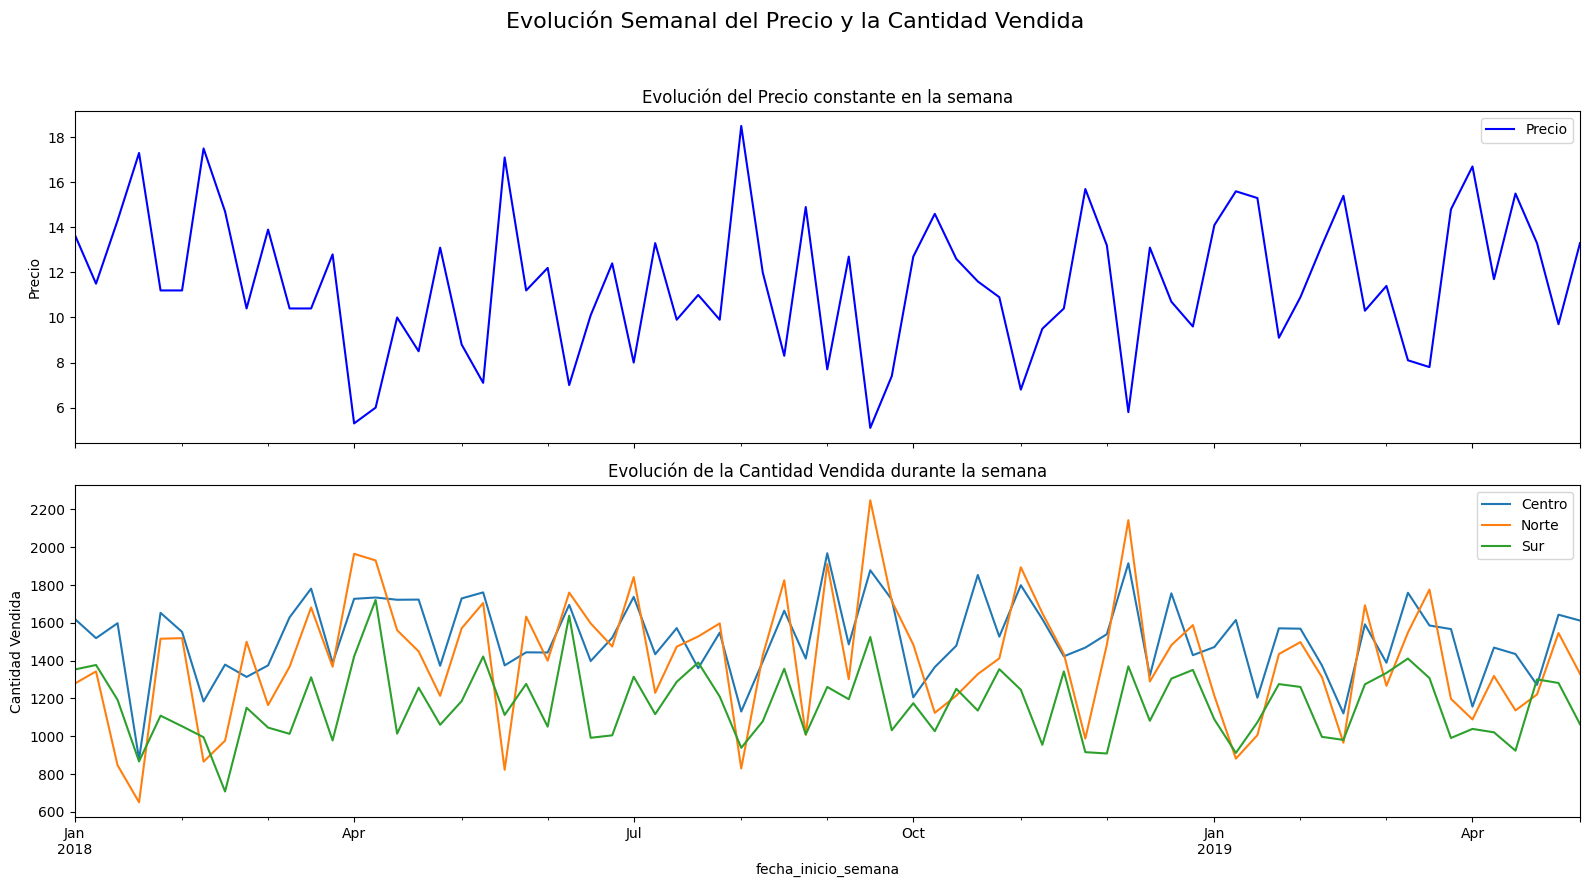

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9), sharex=True)

weekly_data.set_index('fecha_inicio_semana')['precio'].plot(
    ax=axes[0], color='blue', label='Precio')
axes[0].set_title('Evolución del Precio constante en la semana')
axes[0].set_ylabel('Precio')
axes[0].legend()

weekly_data.set_index('fecha_inicio_semana')[['Centro','Norte','Sur']].plot(
    ax=axes[1])
axes[1].set_title('Evolución de la Cantidad Vendida durante la semana')
axes[1].set_ylabel('Cantidad Vendida')
axes[1].legend()

fig.suptitle('Evolución Semanal del Precio y la Cantidad Vendida', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título principal
plt.show()

## Relación entre cantidad y precio

In [15]:
weekly_data_melt = weekly_data.melt(id_vars=['fecha_inicio_semana','precio'])
weekly_data_melt.rename(columns={'variable':'zona','value':'cantidad'},inplace=True)
weekly_data_melt.head()

,fecha_inicio_semana,precio,zona,cantidad
0,2018-01-01,13.7,Centro,1622.0
1,2018-01-08,11.5,Centro,1519.0
2,2018-01-15,14.3,Centro,1598.0
3,2018-01-22,17.3,Centro,879.0
4,2018-01-29,11.2,Centro,1653.0


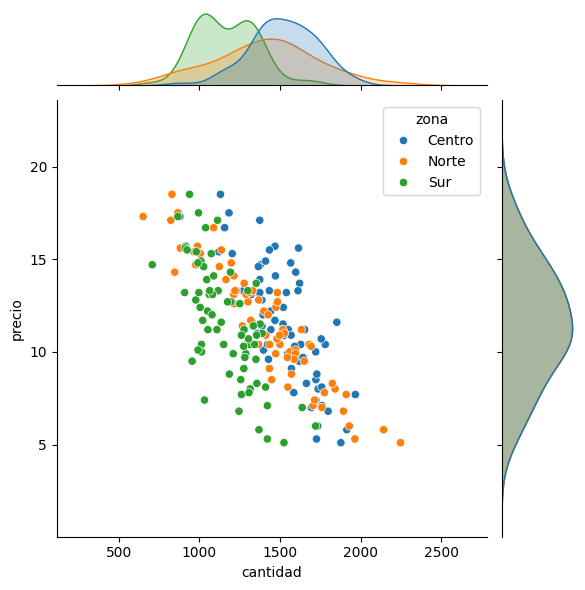

In [16]:
sns.jointplot(weekly_data_melt,x='cantidad',y='precio',hue='zona')

## Determinando tipo de elasticidad

### Ecuación de la demanda lineal
La forma general de una función de demanda lineal es:

$$
Q = a - bP
$$

Donde:
- $Q$: Cantidad demandada.
- $P$: Precio del bien.
- $a$: Intersección con el eje de cantidad (demanda máxima cuando el precio es 0).
- $b$: Pendiente de la curva de demanda (cambio en $Q$ ante un cambio en $P$).



#### Estimando el modelo

In [17]:
elast_var = smf.ols(formula='cantidad ~ precio', data=weekly_data_melt).fit()

In [18]:
print(elast_var.summary())

                            OLS Regression Results                            
Dep. Variable:               cantidad   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     187.9
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           5.27e-31
Time:                        09:34:54   Log-Likelihood:                -1438.8
No. Observations:                 213   AIC:                             2882.
Df Residuals:                     211   BIC:                             2888.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2094.6851     55.038     38.059      0.0

### Ecuación de demanda logaritmica

#### **Ecuación de la demanda log-log**
En un modelo log-log, la relación entre la cantidad demandada ($Q$) y el precio ($P$) es:

$$
\ln(Q) = \alpha + \beta \ln(P)
$$

Donde:
- $\ln$: Logaritmo natural.
- $\alpha$: Intercepto (constante del modelo).
- $\beta$: Coeficiente de elasticidad precio de la demanda.

In [19]:
elast_cte = smf.ols(formula='np.log(cantidad) ~ np.log(precio)', data=weekly_data_melt).fit()

In [20]:
print(elast_cte.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(cantidad)   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     163.5
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           4.29e-28
Time:                        09:34:54   Log-Likelihood:                 84.262
No. Observations:                 213   AIC:                            -164.5
Df Residuals:                     211   BIC:                            -157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.3791      0.093     89.

### Comparando modelos

In [21]:
# Obtener R²
r2_linear = elast_var.rsquared
r2_loglog = elast_cte.rsquared

In [22]:
range_price = np.arange(4,22.1,0.1)
price_data = pd.DataFrame({'precio': range_price})
price_data['elast_var'] = elast_var.predict(price_data)
price_data['elast_cte'] = np.exp(elast_cte.predict(price_data))
price_data.sort_values('precio',inplace=True)

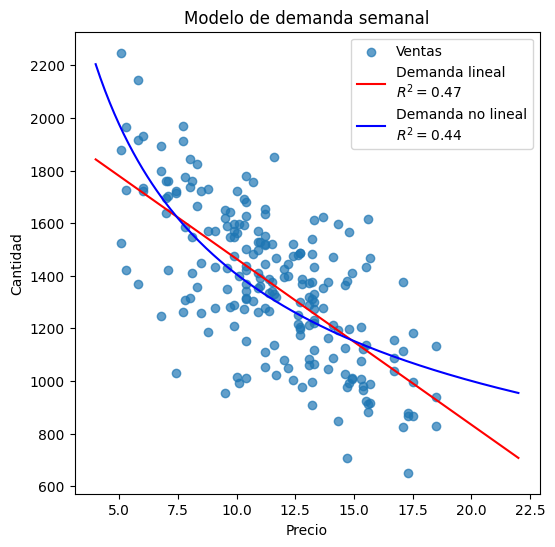

In [23]:
# Gráficos
plt.figure(figsize=(6, 6))
plt.scatter(weekly_data_melt['precio'], weekly_data_melt['cantidad'], label='Ventas', alpha=0.7)
plt.plot(price_data['precio'], price_data['elast_var'], color='red', label=f'Demanda lineal\n$R^2={r2_linear:.2f}$')
plt.plot(price_data['precio'], price_data['elast_cte'], color='blue', label=f'Demanda no lineal\n$R^2={r2_loglog:.2f}$')
plt.xlabel('Precio')
plt.ylabel('Cantidad')
plt.title('Modelo de demanda semanal')
plt.legend()
plt.show()

### Comparando elasticidades

In [24]:
range_price_df = pd.DataFrame({'precio': range_price})

# Predicciones de cantidad
predicted_quantity = elast_var.predict(range_price_df)

# Elasticidad precio de la demanda
range_price_df['elasticity_total'] = elast_var.params['precio'] * (range_price / predicted_quantity)

In [25]:
# Encontrar el índice del valor más cercano a 1 en la columna 'elasticity'
closest_to_zero_index = (range_price_df['elasticity_total'] + 1).abs().idxmin()

# Obtener el precio y la elasticidad correspondientes
closest_price = range_price_df.loc[closest_to_zero_index, 'precio']
closest_elasticity = range_price_df.loc[closest_to_zero_index, 'elasticity_total']

# Mostrar los resultados
print(f"El precio más cercano a elasticidad = 1 es {closest_price:.2f}, con una elasticidad de {closest_elasticity:.6f}")

El precio más cercano a elasticidad = 1 es 16.60, con una elasticidad de -0.999105


In [26]:
cte_elasticity = elast_cte.params['np.log(precio)']
print(f"La elasticidad constante en el modelo log log es: {cte_elasticity:.1f}")

La elasticidad constante en el modelo log log es: -0.5


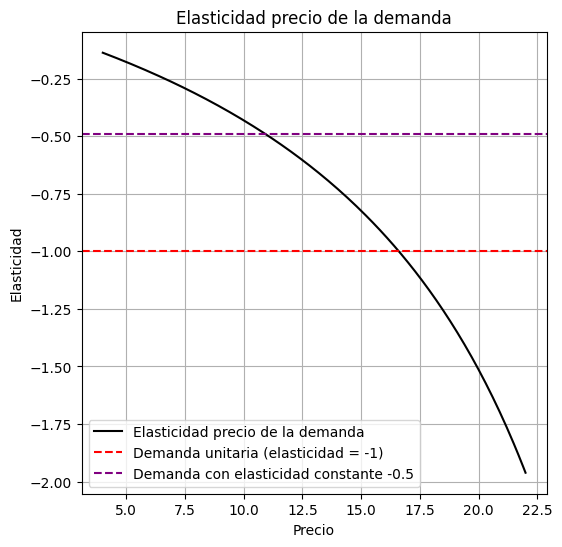

In [27]:
plt.figure(figsize=(6, 6))
plt.plot(range_price, range_price_df['elasticity_total'], label='Elasticidad precio de la demanda', color='black')
plt.axhline(y=-1, color='red', linestyle='--', label='Demanda unitaria (elasticidad = -1)')
plt.axhline(y=cte_elasticity, color='purple', linestyle='--', label=f'Demanda con elasticidad constante {cte_elasticity:.1f}')
plt.title('Elasticidad precio de la demanda')
plt.xlabel('Precio')
plt.ylabel('Elasticidad')
plt.legend()
plt.grid()
plt.show()

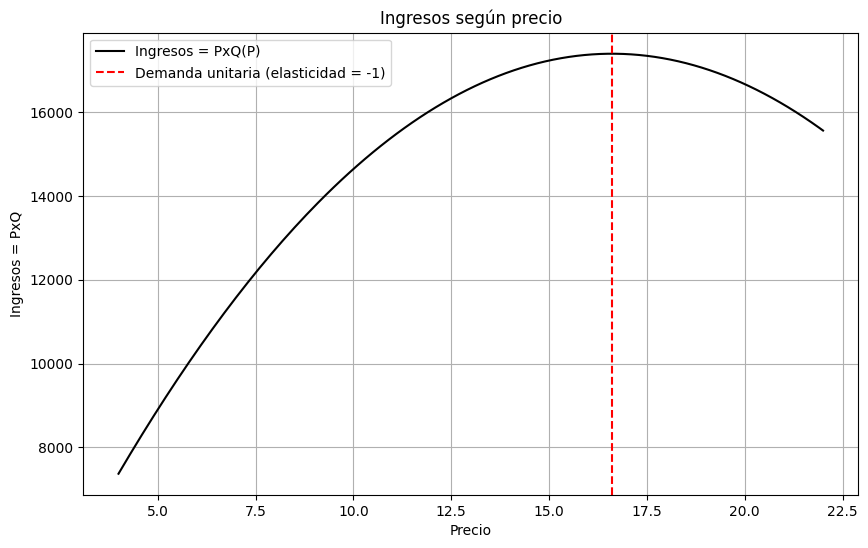

In [28]:
ingresos = range_price * predicted_quantity
plt.figure(figsize=(10, 6))
plt.plot(range_price, ingresos, label='Ingresos = PxQ(P)', color='black')
plt.axvline(x=closest_price, color='red', linestyle='--', label='Demanda unitaria (elasticidad = -1)')
plt.title('Ingresos según precio')
plt.xlabel('Precio')
plt.ylabel('Ingresos = PxQ')
plt.legend()
plt.grid()
plt.show()

### Conclusión

El mejor modelo es el lineal, por tener un $R^2=47$, y nos sugiere poner un precio de 16.6, a aplicarse en todas las zonas.

## Segmentando por zona

### Modelo Lineal por Zona y Ventas Semanales:

$$
Q_{z,t} = b_0^z + b_1^z \cdot \text{Precio}_t + \epsilon_{z,t}
$$

Donde:
- $Q_{z,t}$: Ventas semanales en la zona $z$ y semana $t$.
- $b_0^z$: Intercepto para la zona $z$.
  - Para **centro**: $b_0^{\text{centro}} = b_0$.
  - Para **norte**: $b_0^{\text{norte}} = b_0 + b_0^{\text{norte}}$.
  - Para **sur**: $b_0^{\text{sur}} = b_0 + b_0^{\text{sur}}$.
  
- $b_1^z$: Pendiente para la zona $z$, que ajusta cómo el precio influye en las ventas.
  - Para **centro**: $b_1^{\text{centro}} = b_1$.
  - Para **norte**: $b_1^{\text{norte}} = b_1 + b_1^{\text{norte}}$.
  - Para **sur**: $b_1^{\text{sur}} = b_1 + b_1^{\text{sur}}$.

- $\epsilon_{z,t}$: Error para la zona $z$ y semana $t$, que captura las variaciones no explicadas en las ventas.

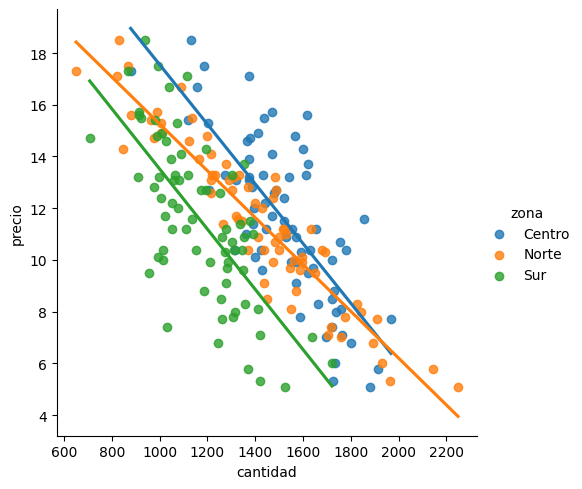

In [29]:
sns.lmplot(
    data=weekly_data_melt,
    x='cantidad',
    y='precio',
    hue='zona',
    ci=None
)

### Explicación:
- **$b_0^z$**: El intercepto ajustado para cada zona, reflejando las ventas base en cada zona sin considerar el precio.
- **$b_1^z$**: La pendiente que ajusta cómo las ventas en cada zona responden al precio. Cada zona puede tener una sensibilidad diferente al precio.
- **$\epsilon_{z,t}$**: El término de error, que incluye otros factores que afectan las ventas semanales en cada zona.

Este modelo refleja cómo las ventas semanales se ven afectadas por el precio, con interceptos y pendientes diferenciados por zona.

### Elasticidad-Precio de la Demanda:

$$
\text{Elasticidad}_{z,t} = \frac{\partial Q_{z,t}}{\partial \text{Precio}_t} \cdot \frac{\text{Precio}_t}{Q_{z,t}}
$$

Donde:

- $\frac{\partial Q_{z,t}}{\partial \text{Precio}_t} = b_1^z$, el coeficiente de la pendiente con respecto al precio.
- $\text{Precio}_t$ es el precio en la semana $t$.
- $Q_{z,t}$ es la cantidad demandada en la zona $z$ y semana $t$, que se puede calcular usando el modelo de regresión.


### Reemplazando en la fórmula:

$$
\text{Elasticidad}_{z,t} = b_1^z \cdot \frac{\text{Precio}_t}{Q_{z,t}}
$$

### Pasos para calcular la elasticidad:

1. **Obtener los parámetros de la regresión**:
   $b_1^z$ (coeficiente de pendiente) para cada zona $z$, que indica cómo cambia la cantidad demandada con el precio.

2. **Calcular $Q_{z,t}$**:
   Para obtener $Q_{z,t}$, usamos el modelo de regresión:
   $$
   Q_{z,t} = b_0^z + b_1^z \cdot \text{Precio}_t
   $$
   Aquí, $b_0^z$ es el intercepto y $b_1^z$ es la pendiente para la zona $z$.

3. **Calcular la elasticidad**:
   Sustituyendo los valores obtenidos:
   $$
   \text{Elasticidad}_{z,t} = b_1^z \cdot \frac{\text{Precio}_t}{b_0^z + b_1^z \cdot \text{Precio}_t}
   $$

### Estimando modelo segmentando zona

In [30]:
elast_var_z = smf.ols(formula='cantidad ~ precio*zona', data=weekly_data_melt).fit()
r2_linear_z = elast_var_z.rsquared
print(elast_var_z.summary())

                            OLS Regression Results                            
Dep. Variable:               cantidad   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     168.4
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           6.55e-71
Time:                        09:34:56   Log-Likelihood:                -1333.8
No. Observations:                 213   AIC:                             2680.
Df Residuals:                     207   BIC:                             2700.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2097.6975 

In [31]:
# Crear las zonas
zonas = ['Centro', 'Sur', 'Norte']

# Crear todas las combinaciones de precio y zona
pred_data = pd.DataFrame({
    'precio': np.repeat(range_price, len(zonas)),
    'zona': zonas * len(range_price)
})

# Estimar las cantidades utilizando el modelo ajustado
pred_data['cantidad'] = elast_var_z.predict(pred_data).astype(int)
pred_data.head()

,precio,zona,cantidad
0,4.0,Centro,1897
1,4.0,Sur,1490
2,4.0,Norte,2139
3,4.1,Centro,1892
4,4.1,Sur,1485


In [32]:
pred_data2 = pred_data.pivot_table(index='precio',columns='zona',values='cantidad')
pred_data2.head()

zona,Centro,Norte,Sur
precio,,,
4.0,1897.0,2139.0,1490.0
4.1,1892.0,2129.0,1485.0
4.2,1887.0,2120.0,1481.0
4.3,1882.0,2110.0,1477.0
4.4,1877.0,2100.0,1473.0


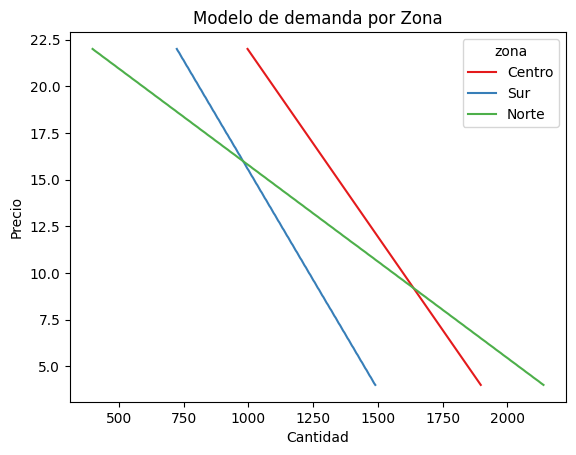

In [33]:
sns.lineplot(data=pred_data, x='cantidad', y='precio', hue='zona', palette='Set1')

# Agregar título y etiquetas
plt.title('Modelo de demanda por Zona')
plt.xlabel('Cantidad')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

### Elasticidades por zona

In [34]:
b0, b0_n, b0_s, b1, b1_n, b1_s= elast_var_z.params

In [35]:
# Imprimir las ecuaciones de demanda por zona
print(f'Ecuación de demanda para la zona de referencia (Centro):')
print(f'Cantidad = {b0:.2f} + {b1:.2f} * Precio')

print(f'\nEcuación de demanda para la zona Norte:')
print(f'Cantidad = {b0 + b0_n:.2f} + ({b1 + b1_n:.2f}) * Precio')

print(f'\nEcuación de demanda para la zona Sur:')
print(f'Cantidad = {b0 + b0_s:.2f} + ({b1 + b1_s:.2f}) * Precio')

Ecuación de demanda para la zona de referencia (Centro):
Cantidad = 2097.70 + -49.99 * Precio

Ecuación de demanda para la zona Norte:
Cantidad = 2526.13 + (-96.68) * Precio

Ecuación de demanda para la zona Sur:
Cantidad = 1660.23 + (-42.53) * Precio


In [36]:
range_price_df['elasticity_centro'] = ( b1  * (range_price / pred_data2['Centro'])).values
range_price_df['elasticity_norte'] = ((b1 + b1_n) * (range_price / pred_data2['Norte'])).values
range_price_df['elasticity_sur'] = ((b1 + b1_s) * (range_price / pred_data2['Sur'])).values

In [37]:
range_price_df.head()

,precio,elasticity_total,elasticity_centro,elasticity_norte,elasticity_sur
0,4.0,-0.136917,-0.105405,-0.180790,-0.114169
1,4.1,-0.140821,-0.108326,-0.186181,-0.117417
2,4.2,-0.144753,-0.111262,-0.191531,-0.120606
3,4.3,-0.148712,-0.114214,-0.197021,-0.123812
4,4.4,-0.152699,-0.117181,-0.202563,-0.127035


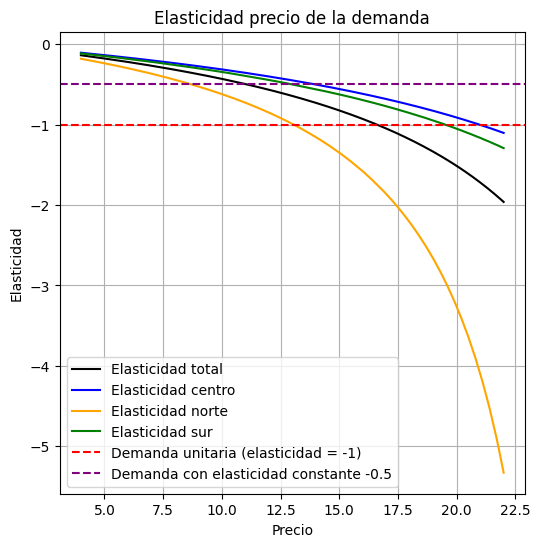

In [38]:
plt.figure(figsize=(6, 6))
plt.plot(range_price, range_price_df['elasticity_total'], label='Elasticidad total', color='black')
plt.plot(range_price, range_price_df['elasticity_centro'], label='Elasticidad centro', color='blue')
plt.plot(range_price, range_price_df['elasticity_norte'], label='Elasticidad norte', color='orange')
plt.plot(range_price, range_price_df['elasticity_sur'], label='Elasticidad sur', color='green')
plt.axhline(y=-1, color='red', linestyle='--', label='Demanda unitaria (elasticidad = -1)')
plt.axhline(y=cte_elasticity, color='purple', linestyle='--', label=f'Demanda con elasticidad constante {cte_elasticity:.1f}')
plt.title('Elasticidad precio de la demanda')
plt.xlabel('Precio')
plt.ylabel('Elasticidad')
plt.legend()
plt.grid()
plt.show()

### Optimizacion de ingresos

In [39]:
# Encontrar el índice del valor más cercano a 1 en la columna 'elasticity'
closest_to_zero_index_c = (range_price_df['elasticity_centro'] + 1).abs().idxmin()
closest_price_c = range_price_df.loc[closest_to_zero_index_c, 'precio']

closest_to_zero_index_n = (range_price_df['elasticity_norte'] + 1).abs().idxmin()
closest_price_n = range_price_df.loc[closest_to_zero_index_n, 'precio']

closest_to_zero_index_s = (range_price_df['elasticity_sur'] + 1).abs().idxmin()
closest_price_s = range_price_df.loc[closest_to_zero_index_s, 'precio']

In [40]:
print(f"El precio más cercano en Centro a elasticidad = 1 es \t{closest_price_c:.2f}")
print(f"El precio más cercano en Norte a elasticidad = 1 es \t{closest_price_n:.2f}")
print(f"El precio más cercano en Sur a elasticidad = 1 es \t{closest_price_s:.2f}")

El precio más cercano en Centro a elasticidad = 1 es 	21.00
El precio más cercano en Norte a elasticidad = 1 es 	13.10
El precio más cercano en Sur a elasticidad = 1 es 	19.50


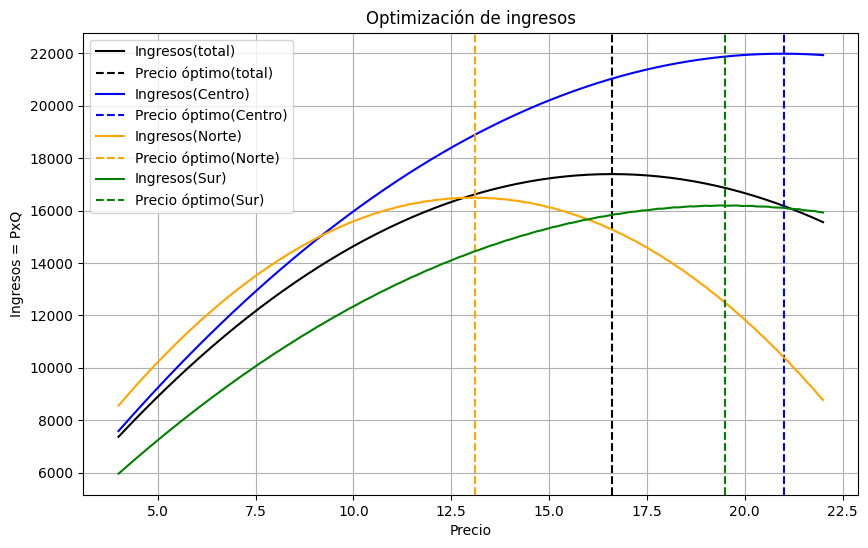

In [41]:
ingresos = range_price * predicted_quantity
plt.figure(figsize=(10, 6))

plt.plot(range_price, ingresos, label='Ingresos(total)', color='black')
plt.axvline(x=closest_price, color='black', linestyle='--', label='Precio óptimo(total)')

plt.plot(range_price, pred_data2['Centro']*range_price, label='Ingresos(Centro)', color='blue')
plt.axvline(x=closest_price_c, color='blue', linestyle='--', label='Precio óptimo(Centro)')

plt.plot(range_price, pred_data2['Norte']*range_price, label='Ingresos(Norte)', color='orange')
plt.axvline(x=closest_price_n, color='orange', linestyle='--', label='Precio óptimo(Norte)')

plt.plot(range_price, pred_data2['Sur']*range_price, label='Ingresos(Sur)', color='green')
plt.axvline(x=closest_price_s, color='green', linestyle='--', label='Precio óptimo(Sur)')

plt.title('Optimización de ingresos')
plt.xlabel('Precio')
plt.ylabel('Ingresos = PxQ')
plt.legend()
plt.grid()
plt.show()